#### Imports

In [1]:
import textwrap
import tempfile

from pathlib import Path

from file_handling.pipeline_input_handling.pipeline_input_file_manager import PipelineInputFileManager

from file_handling.pipeline_configuration_handling.pipeline_configuration_file_manager import \
    PipelineConfigurationFileManager

from data_classes.pipeline_configuration.pipeline_configuration_data import PipelineConfigurationData
from data_classes.pipeline_configuration.pipeline_configuration import PipelineConfiguration

from data_classes.pipeline_input.pipeline_input_data import PipelineInputData
from data_classes.pipeline_input.pipeline_input import PipelineInput

from pipeline_entities.pipeline.pipeline import Pipeline
from pipeline_entities.pipeline.pipeline_builder.pipeline_builder import PipelineBuilder

from pipeline_entities.pipeline_execution.pipeline_manager.pipeline_manager import PipelineManager

from setup_manager.internal_logic_setup_manager import InternalLogicSetupManager

import matplotlib.pyplot as plt

#### Setup

In [2]:
InternalLogicSetupManager.setup()

#### Pipeline configuration

In [3]:
pipeline_configuration_file_content: bytes = textwrap.dedent("""\
    name="Runtime comparison between Aitken-Neville variants"
    supported_program_version=Version(\"1.0.0\")
    components=DirectionalAcyclicGraph(\"\"\"
        0=Base Input
        1=Equidistant Node Generator
            predecessors=["0"]
        2=Function Expression Input
            predecessors=["1"]
        3=Interpolation Values Evaluator
            predecessors=["2"]
        4=Aitken Neville Interpolation
           predecessors=["3"]
        5=Interpolant Evaluator
           predecessors=["4"]
        6=Aitken Neville Evaluator
           predecessors=["3"]
        7=Newton Interpolation
           predecessors=["3"]
        8=Interpolant Evaluator
           predecessors=["7"]
        9=Barycentric1 Interpolation
           predecessors=["3"]
        10=Interpolant Evaluator
           predecessors=["9"]
        11=Barycentric2 Interpolation
           predecessors=["3"]
        12=Interpolant Evaluator
           predecessors=["11"]
        \"\"\")
    extra_value=True

    runs_for_component_execution_time_measurements=10
    """).encode("utf-8")

In [4]:
temp_dir = tempfile.TemporaryDirectory()
temp_pipeline_configuration_file = Path(temp_dir.name + "/pipeline_configuration.ini")

with open(temp_pipeline_configuration_file, "wb") as f:
    f.write(pipeline_configuration_file_content)

In [5]:
pipeline_configuration_data: PipelineConfigurationData = PipelineConfigurationFileManager.load_from_file(temp_pipeline_configuration_file)
pipeline_configuration: PipelineConfiguration = PipelineConfiguration(pipeline_configuration_data)

#### Pipeline input

In [6]:
def generate_pipeline_input_file_content(node_count: int) -> bytes:
    return textwrap.dedent(f"""\
        name="PipelineInput {node_count}"
        data_type=jax.numpy.float16
        node_count={node_count}
        interpolation_interval=jax.numpy.array([-1, 1])
        interpolant_evaluation_points=jax.numpy.linspace(-1, 1, 10)
        function_expression="sin(10*x)"
        sympy_function_expression_simplification=True
        """).encode("utf-8")


def generate_pipeline_input(node_count: int) -> PipelineInput:
    temp_pipeline_input_file: Path = Path(temp_dir.name + "/pipeline_input.ini")
    pipeline_input_file_content: bytes = generate_pipeline_input_file_content(node_count)

    with open(temp_pipeline_input_file, "wb") as f:
        f.write(pipeline_input_file_content)

    pipeline_input_data: PipelineInputData = PipelineInputFileManager.load_from_file(temp_pipeline_input_file)
    pipeline_input: PipelineInput = PipelineInput(pipeline_input_data)
    return pipeline_input

#### Pipeline generation

In [7]:
def generate_pipeline_manager(node_count: int) -> PipelineManager:
    pipeline_input: PipelineInput = generate_pipeline_input(node_count)
    pipeline: Pipeline = PipelineBuilder.build(pipeline_configuration, pipeline_input)
    pipeline_manager: PipelineManager = PipelineManager(pipeline)
    return pipeline_manager

#### Execution

In [8]:
pipeline_managers = {}

def retrieve_aitken_neville_interpolation_runtime(manager: PipelineManager) -> float:
    core_report = manager.get_component_execution_report("4")
    evaluator_report = manager.get_component_execution_report("5")

    return core_report.average_component_execution_time + evaluator_report.average_component_execution_time

def retrieve_aitken_neville_evaluator_runtime(manager: PipelineManager) -> float:
    evaluator_report = manager.get_component_execution_report("6")

    return evaluator_report.average_component_execution_time

def retrieve_newton_interpolation_runtime(manager: PipelineManager) -> float:
    core_report = manager.get_component_execution_report("7")
    evaluator_report = manager.get_component_execution_report("8")

    return core_report.average_component_execution_time + evaluator_report.average_component_execution_time

def retrieve_barycentric_1_interpolation_runtime(manager: PipelineManager) -> float:
    core_report = manager.get_component_execution_report("9")
    evaluator_report = manager.get_component_execution_report("10")

    return core_report.average_component_execution_time + evaluator_report.average_component_execution_time

def retrieve_barycentric_2_interpolation_runtime(manager: PipelineManager) -> float:
    core_report = manager.get_component_execution_report("11")
    evaluator_report = manager.get_component_execution_report("12")

    return core_report.average_component_execution_time + evaluator_report.average_component_execution_time

def measure_runtime(node_count: int) -> tuple[float, float, float, float, float]:
    pipeline_manager: PipelineManager = generate_pipeline_manager(node_count)
    pipeline_managers[node_count] = pipeline_manager
    pipeline_manager.execute_all()

    runtime_dict = {"aitken_interpolation": retrieve_aitken_neville_interpolation_runtime(pipeline_manager),
                    "aitken_evaluator": retrieve_aitken_neville_evaluator_runtime(pipeline_manager),
                    "newton_interpolation": retrieve_newton_interpolation_runtime(pipeline_manager),
                    "barycentric1_interpolation": retrieve_barycentric_1_interpolation_runtime(pipeline_manager),
                    "barycentric2_interpolation": retrieve_barycentric_2_interpolation_runtime(pipeline_manager)}

    return runtime_dict

1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 


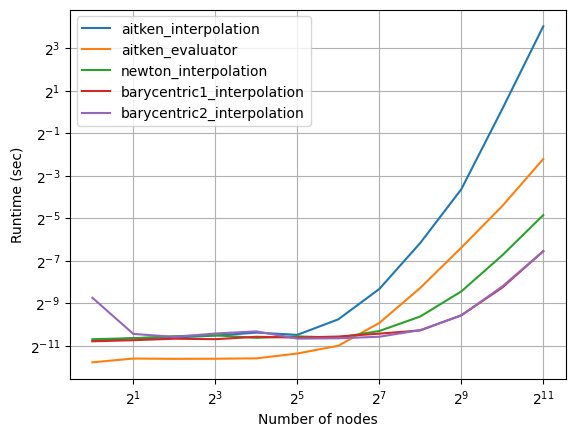

In [9]:
node_counts: list = [2 ** i for i in range(0, 12)]

runtime_list_dict = {"aitken_interpolation": [],
                "aitken_evaluator": [],
                "newton_interpolation": [],
                "barycentric1_interpolation": [],
                "barycentric2_interpolation": []}

for node_count in node_counts:
    runtime_dict = measure_runtime(node_count)

    for name, runtime in runtime_dict.items():
        runtime_list_dict[name].append(runtime)

    print(node_count, end=", ")

print("")

for name, runtime_list in runtime_list_dict.items():
    plt.plot(node_counts, runtime_list, label=name)

plt.xlabel("Number of nodes")
plt.ylabel("Runtime (sec)")
plt.legend()

plt.yscale("log", base=2)
plt.xscale("log", base=2)

plt.grid(True)

plt.show()